<a href="https://colab.research.google.com/github/promckkon/MK-DCNN/blob/main/MK-DCNN%20with%200dB%20NOISE%20in%20CWRU%20Dataset%20250917.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [3]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_0_faults.csv',index=False)

/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F1_B007_1_124.mat
['F1_B007_1_124']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F2_B014_1_191.mat
['F1_B007_1_124' 'F2_B014_1_191']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F3_B021_1_228.mat
['F1_B007_1_124' 'F2_B014_1_191' 'F3_B021_1_228']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F4_IR007_1_111.mat
['F1_B007_1_124' 'F2_B014_1_191' 'F3_B021_1_228' 'F4_IR007_1_111']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F5_IR014_1_176.mat
['F1_B007_1_124' 'F2_B014_1_191' 'F3_B021_1_228' 'F4_IR007_1_111'
 'F5_IR014_1_176']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F6_IR021_1_215.mat
['F1_B007_1_124' 'F2_B014_1_191' 'F3_B021_1_228' 'F4_IR007_1_111'
 'F5_IR014_1_176' 'F6_IR021_1_215']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F7_OR007_6_1_137.mat
['F1_B007_1_124' 'F2_B014_1_191' 'F3_B021_1_228' 'F4_IR007_1_111'
 'F5_IR014_1_176' 'F6_IR021_1_215' 'F7_OR007_6_1_137']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F8_OR014_6_1_203.mat
['

# Multi-Kernel Deep 1D-CNN

In [4]:
pip install tensorflow

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [6]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras import backend as K

# --- Custom Physics-Informed Loss Function ---
def custom_loss(y_true, y_pred):
    # Standard categorical crossentropy
    loss = K.categorical_crossentropy(y_true, y_pred)

    # Physics-Informed Term: penalize rapid class probability changes
    # Ensure y_pred is at least 2D for slicing
    if K.ndim(y_pred) < 2:
        y_pred = K.expand_dims(y_pred, axis=-1)

    # Ensure y_pred has more than one class dimension to compute diff
    if K.int_shape(y_pred)[-1] > 1:
        diff = y_pred[:, 1:] - y_pred[:, :-1]
        squared_diff = tf.square(diff)
        physics_term = tf.reduce_mean(squared_diff)
    else:
        physics_term = 0.0 # No physics term if only one class


    # Total loss = classification loss + regularization term
    total_loss = loss + 0.01 * physics_term  # 0.01 is tunable

    return total_loss

# --- Model Definition ---
# no_classes = len(df['fault'].unique()) # Original line that caused 10 classes
no_classes = len(encoder.classes_) # Use the encoder to get the correct number of classes
print(f"Number of output classes (no_classes): {no_classes}") # Add print statement to verify

input_shape = (X.shape[1], X.shape[2])  # Example: (784, 1)

# Head 1
inputs1 = Input(shape=input_shape)
conv1 = Conv1D(filters=64, kernel_size=200, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=20)(drop1)
flat1 = Flatten()(pool1)

# Head 2
inputs2 = Input(shape=input_shape)
conv2 = Conv1D(filters=64, kernel_size=100, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=10)(drop2)
flat2 = Flatten()(pool2)

# Head 3
inputs3 = Input(shape=input_shape)
conv3 = Conv1D(filters=64, kernel_size=50, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=5)(drop3)
flat3 = Flatten()(pool3)

# Merge all feature paths
merged = concatenate([flat1, flat2, flat3])

# Fully connected interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(no_classes, activation='softmax')(dense1)

# Build and compile model with custom loss
cnn_model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
cnn_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# Model summary
cnn_model.summary()

Number of output classes (no_classes): 10


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2706, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2706, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2706, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2507, 64)  │     12,864 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 2607, 64)  │      6,464 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2657, 64)  │      3,264 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2507, 64)  │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2607, 64)  │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2657, 64)  │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 125, 64)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 260, 64)   │          0 │ dropout_1[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 531, 64)   │          0 │ dropout_2[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8000)      │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 16640)     │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 33984)     │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 58624)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100)       │  5,862,500 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │      1,010 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,886,102 (22.45 MB)

 Trainable params: 5,886,102 (22.45 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
batch_size =100
epochs = 20
history = cnn_model.fit([X_train,X_train,X_train], y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=([X_test,X_test,X_test],y_test),shuffle=True)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 769ms/step - accuracy: 0.1448 - loss: 3.8241 - val_accuracy: 0.2912 - val_loss: 1.9032
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.3952 - loss: 1.6056 - val_accuracy: 0.5468 - val_loss: 1.3557
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7151 - loss: 0.8857 - val_accuracy: 0.8276 - val_loss: 0.8287
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8859 - loss: 0.4268 - val_accuracy: 0.8648 - val_loss: 0.4987
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9220 - loss: 0.2041 - val_accuracy: 0.8618 - val_loss: 0.4041
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9450 - loss: 0.1454 - val_accuracy: 0.9316 - val_loss: 0.3181
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9842 - loss: 0.0893 - val_accuracy: 0.9302 - val_loss: 0.2667
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9909 - loss: 0.0538 - val_accuracy: 0.9614 

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


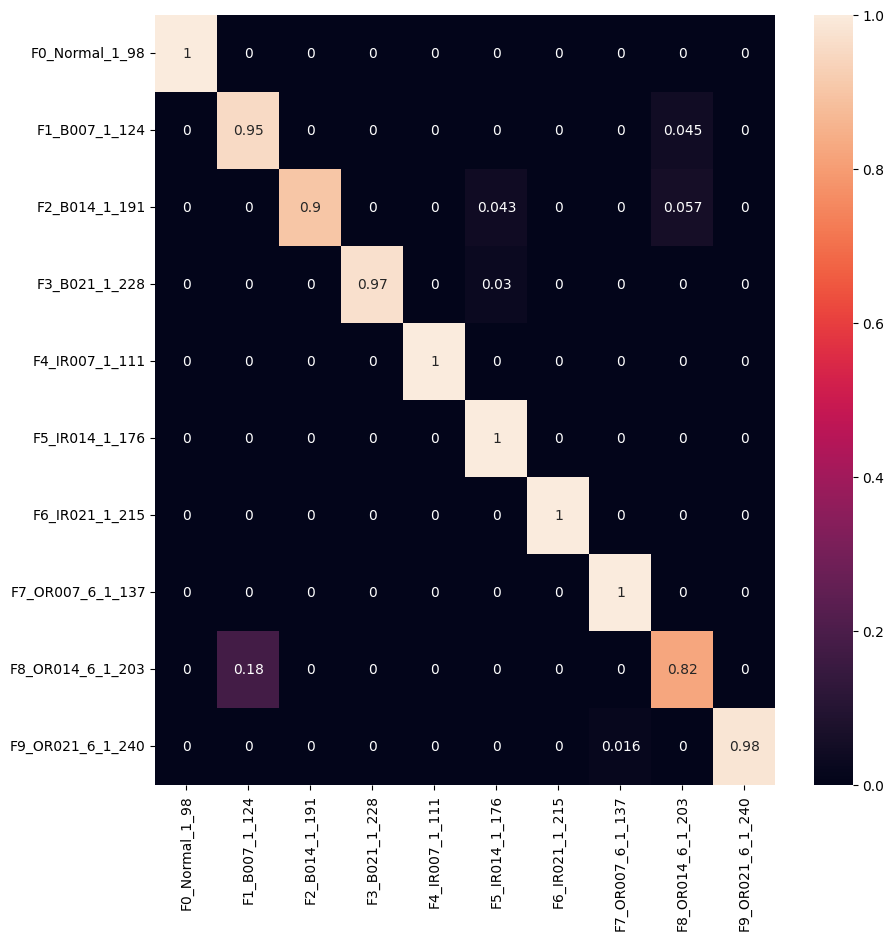

In [9]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict([X_test,X_test,X_test])


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)

In [10]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[16].output)
y_viz = dummy_cnn.predict([X_train,X_train,X_train])

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1570 samples in 0.001s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 1570 samples in 0.098s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1570
[t-SNE] Computed conditional probabilities for sample 1570 / 1570
[t-SNE] Mean sigma: 2.039984
[t-SNE] Computed conditional probabilities in 0.053s
[t-SNE] Iteration 50: error = 57.6001663, gradient norm = 0.0380575 (50 iterations in 0.655s)
[t-SNE] Iteration 100: error = 52.4893646, gradient norm = 0.0140447 (50 iterations in 0.514s)
[t-SNE] Iteration 150: error = 51.2009087, gradient norm = 0.0104668 (50 iterations in 0.484s)
[t-SNE] Iteration 200: error = 50.5960693, gradient norm = 0.0062149 (50 iterations in 0.498s)
[t-SNE] Iteration 250: error = 50.2337418, gradient norm = 0.0051033 (50 iterations in 0.475s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.233742
[t-SNE] Iteration 300: error = 0.9114842, gradient norm = 0.0157520 (50 iterations in 0.644s)
[t-SNE] Iteration 350: error = 0.6573026, gradient norm = 0.0143897 (50 iterations 

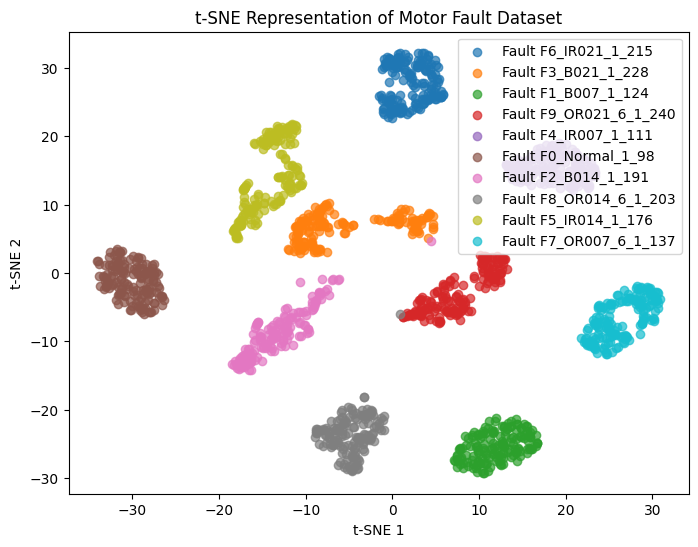

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE transformation
X_t_sne = TSNE(
    n_components=2,
    learning_rate='auto',
    verbose=2,  # Increase verbosity for more detailed feedback
    perplexity=40,
    n_iter=500  # Slightly increased number of iterations for convergence
).fit_transform(y_viz)

# Create DataFrame for t-SNE components
tSNEdf = pd.DataFrame(data=X_t_sne, columns=['T-SNE component 1', 'T-SNE component 2'])

# Assuming `inv_Transform_result` transforms `y_train` to get the Fault labels
tSNEdf['Fault'] = inv_Transform_result(y_train)

# Save the t-SNE DataFrame as a CSV file
tSNEdf.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_tSNE_results.csv', index=True)
print("t-SNE results saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_tSNE_results.csv'.")

# # Plot the t-SNE results with Fault as hue
# plt.figure(figsize=(12, 12))  # Larger figure for clarity
# sns.scatterplot(
#     x='T-SNE component 1',
#     y='T-SNE component 2',
#     hue='Fault',
#     palette=sns.color_palette("husl", as_cmap=False),  # Vivid color palette
#     data=tSNEdf,
#     legend="full",
#     alpha=0.7,  # Increased transparency for better overlap clarity
#     s=100  # Larger marker size
# )

# # Add gridlines for better visualization
# plt.grid


# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNEdf['Fault'].unique():
    subset = tSNEdf[tSNEdf['Fault'] == label]
    plt.scatter(subset['T-SNE component 1'], subset['T-SNE component 2'], label=f'Fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()

Statistical Features

In [12]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

WINDOW_SIZE = int(average_samples_per_fault / approx_windows_per_fault)
STRIDE = int(WINDOW_SIZE * stride_ratio)

print(f"Calculated WINDOW_SIZE: {WINDOW_SIZE}, STRIDE: {STRIDE}")

# Initialize a list to store statistical features
statistical_features = []

# Loop through each fault type
for f in df['fault'].unique():
    # Extract data for the current fault type
    fault_data = df[df['fault'] == f].iloc[:, 0].values  # Convert to NumPy array for efficiency

    # Compute windows using sliding window approach
    num_windows = (len(fault_data) - WINDOW_SIZE) // STRIDE + 1
    for i in range(num_windows):
        start = i * STRIDE
        end = start + WINDOW_SIZE
        window = fault_data[start:end]

        # Compute statistical features for the current window
        mean_val = np.mean(window)
        std_val = np.std(window)
        rms_val = np.sqrt(np.mean(np.square(window)))
        max_val = np.max(window)
        min_val = np.min(window)
        skewness_val = skew(window)
        kurtosis_val = kurtosis(window)

        # Additional statistical features
        mean_abs_val = np.mean(np.abs(window))
        form_factor = rms_val / mean_abs_val if mean_abs_val != 0 else 0
        crest_factor = max_val / rms_val if rms_val != 0 else 0

        # Store the features in a dictionary
        statistical_features.append({
            'fault': f,
            'window': i + 1,
            'mean': mean_val,
            'std': std_val,
            'rms': rms_val,
            'max': max_val,
            'min': min_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'form_factor': form_factor,
            'crest_factor': crest_factor
        })

# Convert statistical features into a DataFrame
stat_features_df = pd.DataFrame(statistical_features)

# Display the extracted features and count of rows
print(f"Extracted {len(stat_features_df)} rows (target: {TARGET_ROWS})")
print(stat_features_df)

# Save the extracted features to a CSV file
output_file = "/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv"
stat_features_df.to_csv(output_file, index=False)
print(f"Statistical features saved to '{output_file}'.")


Calculated WINDOW_SIZE: 2706, STRIDE: 2164
Extracted 2243 rows (target: 1800)
               fault  window      mean       std       rms       max  \
0      F1_B007_1_124       1  0.014919  0.155983  0.156694  0.585375   
1      F1_B007_1_124       2  0.015372  0.145547  0.146357  0.585375   
2      F1_B007_1_124       3  0.016878  0.140657  0.141666  0.414936   
3      F1_B007_1_124       4  0.016009  0.123387  0.124421  0.438092   
4      F1_B007_1_124       5  0.016391  0.135949  0.136933  0.515906   
...              ...     ...       ...       ...       ...       ...   
2238  F0_Normal_1_98     219  0.013966  0.066277  0.067733  0.220089   
2239  F0_Normal_1_98     220  0.015203  0.064545  0.066311  0.211536   
2240  F0_Normal_1_98     221  0.016827  0.061149  0.063422  0.188588   
2241  F0_Normal_1_98     222  0.015862  0.072285  0.074005  0.317513   
2242  F0_Normal_1_98     223  0.015302  0.066122  0.067869  0.196307   

           min  skewness  kurtosis  form_factor  crest_fa

In [13]:
import pandas as pd
from sklearn.utils import resample

# Load your dataset (replace 'your_dataset.csv' with your actual file)
df = pd.read_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv')

# Display initial class distribution
print("Initial class distribution:")
print(df['fault'].value_counts())

# Target size for undersampling/resampling
TARGET_ROWS = 1570

# Separate all fault types
fault_classes = df['fault'].value_counts()

# Determine the number of classes
num_classes = len(fault_classes)

# Calculate how many samples to take from each class
samples_per_class = TARGET_ROWS // num_classes

# Initialize a list to store resampled data
resampled_data = []

# Loop over each class to resample them
for fault_class in fault_classes.index:
    class_data = df[df['fault'] == fault_class]
    if len(class_data) > samples_per_class:
        # Undersample
        class_data_resampled = resample(class_data, replace=False, n_samples=samples_per_class, random_state=42)
    else:
        # Upsample
        class_data_resampled = resample(class_data, replace=True, n_samples=samples_per_class, random_state=42)

    resampled_data.append(class_data_resampled)

# Concatenate the resampled data into a single DataFrame
balanced_df = pd.concat(resampled_data)

# Check if we have the exact number of rows
current_rows = len(balanced_df)
print(f"Current rows after equal resampling: {current_rows}")

# If the current rows don't match the target rows, adjust by trimming or adding rows
if current_rows > TARGET_ROWS:
    # Trim extra rows (if more than target)
    balanced_df = balanced_df.head(TARGET_ROWS)
elif current_rows < TARGET_ROWS:
    # Add rows if fewer than target, by sampling from existing data
    remaining_rows = TARGET_ROWS - current_rows
    additional_data = balanced_df.sample(n=remaining_rows, replace=True, random_state=42)
    balanced_df = pd.concat([balanced_df, additional_data])

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("New class distribution:")
print(balanced_df['fault'].value_counts())

# Display final row count
print(f"Final row count: {len(balanced_df)}")

# Save the balanced dataset to a CSV file
balanced_df.to_csv("/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv", index=False)
print("Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'")


Initial class distribution:
F6_IR021_1_215      226
F5_IR014_1_176      225
F9_OR021_6_1_240    225
F1_B007_1_124       224
F2_B014_1_191       224
F4_IR007_1_111      224
F3_B021_1_228       224
F7_OR007_6_1_137    224
F8_OR014_6_1_203    224
F0_Normal_1_98      223
Name: fault, dtype: int64
Current rows after equal resampling: 1570
New class distribution:
F0_Normal_1_98      157
F3_B021_1_228       157
F9_OR021_6_1_240    157
F7_OR007_6_1_137    157
F4_IR007_1_111      157
F1_B007_1_124       157
F6_IR021_1_215      157
F5_IR014_1_176      157
F2_B014_1_191       157
F8_OR014_6_1_203    157
Name: fault, dtype: int64
Final row count: 1570
Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'


In [14]:
balanced_df.shape

(1570, 11)

In [15]:
balanced_df=balanced_df.sort_values(by='fault')

In [16]:
balanced_df

,fault,window,mean,std,rms,max,min,skewness,kurtosis,form_factor,crest_factor
0,F0_Normal_1_98,43,0.009751,0.065139,0.065864,0.212996,-0.215708,-0.274433,-0.045461,1.236035,3.233858
412,F0_Normal_1_98,126,0.009053,0.065878,0.066497,0.207990,-0.209450,-0.182528,0.069087,1.252104,3.127817
418,F0_Normal_1_98,39,0.009913,0.066629,0.067362,0.214457,-0.243246,-0.129796,-0.097380,1.238133,3.183623
421,F0_Normal_1_98,41,0.009056,0.062323,0.062978,0.181078,-0.183999,-0.064707,-0.311857,1.232367,2.875268
434,F0_Normal_1_98,171,0.014931,0.068058,0.069677,0.243871,-0.235944,-0.167390,-0.017621,1.233601,3.500033
...,...,...,...,...,...,...,...,...,...,...,...
671,F9_OR021_6_1_240,37,0.019118,0.764205,0.764444,6.993672,-6.522920,-0.190572,27.035617,2.207795,9.148707
992,F9_OR021_6_1_240,68,0.015919,0.368323,0.368667,2.281144,-2.346248,-0.327045,7.737874,1.589529,6.187542
1004,F9_OR021_6_1_240,65,0.016095,0.570980,0.571206,4.146624,-4.914517,-0.877848,22.789508,2.140498,7.259415
317,F9_OR021_6_1_240,45,0.015551,0.652645,0.652830,3.912083,-4.865272,-0.570812,12.225455,1.778703,5.992494


     t-SNE 1    t-SNE 2           fault
0  21.238615 -26.589052  F0_Normal_1_98
1  39.434128  -0.538215  F0_Normal_1_98
2  23.587759   5.944052  F0_Normal_1_98
3  29.598824  25.057808  F0_Normal_1_98
4  38.192833  24.018194  F0_Normal_1_98


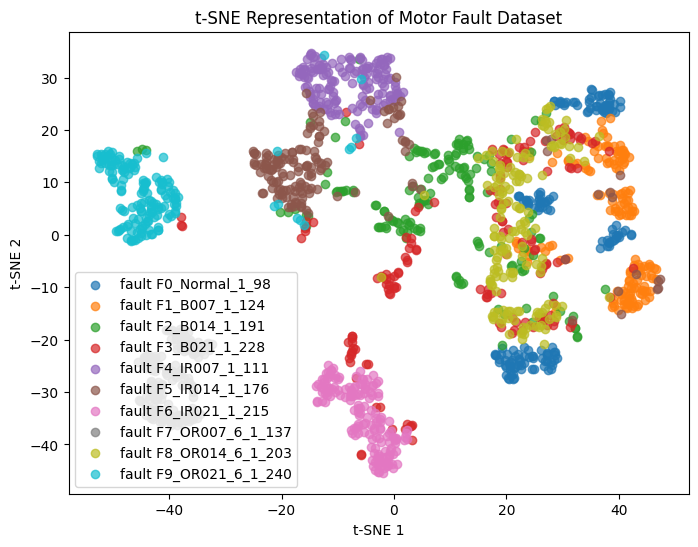

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Sort the dataset by the 'Fault' column
balanced_df = balanced_df.sort_values(by='fault')

# Separate features and target variable
X = balanced_df.drop(columns=['fault'])  # Replace 'Fault' with actual target column name
y = balanced_df['fault']

# Normalize the feature columns using StandardScaler
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Concatenate the normalized features with the target variable
STAT_Motor_Fault_dataset_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

# Sort the normalized dataset by 'Fault' column
STAT_Motor_Fault_dataset_normalized = STAT_Motor_Fault_dataset_normalized.sort_values(by='fault')

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # 2D t-SNE
X_tsne = tsne.fit_transform(X_normalized)

# Create a DataFrame for t-SNE results
tSNE_representation = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tSNE_representation['fault'] = y.reset_index(drop=True)

# Display the t-SNE representation
print(tSNE_representation.head())

# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNE_representation['fault'].unique():
    subset = tSNE_representation[tSNE_representation['fault'] == label]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=f'fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


In [18]:
tSNE_representation

,t-SNE 1,t-SNE 2,fault
0,21.238615,-26.589052,F0_Normal_1_98
1,39.434128,-0.538215,F0_Normal_1_98
2,23.587759,5.944052,F0_Normal_1_98
3,29.598824,25.057808,F0_Normal_1_98
4,38.192833,24.018194,F0_Normal_1_98
...,...,...,...
1565,-44.170494,3.236545,F9_OR021_6_1_240
1566,-44.891064,1.720109,F9_OR021_6_1_240
1567,-46.934151,13.727341,F9_OR021_6_1_240
1568,-51.926868,15.085188,F9_OR021_6_1_240


In [19]:
tSNE_representation=tSNE_representation.drop(columns=['fault'])
tSNE_representation

,t-SNE 1,t-SNE 2
0,21.238615,-26.589052
1,39.434128,-0.538215
2,23.587759,5.944052
3,29.598824,25.057808
4,38.192833,24.018194
...,...,...
1565,-44.170494,3.236545
1566,-44.891064,1.720109
1567,-46.934151,13.727341
1568,-51.926868,15.085188


In [20]:
tSNEdf = tSNEdf.sort_values(by='Fault')

In [21]:
tSNEdf

,T-SNE component 1,T-SNE component 2,Fault
1360,-27.968122,-5.681288,F0_Normal_1_98
1081,-32.319115,-1.693372,F0_Normal_1_98
222,-30.065990,-4.761765,F0_Normal_1_98
1481,-28.929296,0.715307,F0_Normal_1_98
117,-27.581474,-1.244300,F0_Normal_1_98
...,...,...,...
710,12.110247,1.408762,F9_OR021_6_1_240
1014,11.971354,-0.411105,F9_OR021_6_1_240
250,10.363699,0.657516,F9_OR021_6_1_240
1007,6.632702,-1.084270,F9_OR021_6_1_240


Combined Features

In [22]:
# import pandas as pd

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)
Motor_Fault_dataset=Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)

# Sort the dataset by 'Fault' column
Motor_Fault_dataset = Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset


,t-SNE 1,t-SNE 2,T-SNE component 1,T-SNE component 2,Fault
1360,38.260838,-11.781316,-27.968122,-5.681288,F0_Normal_1_98
1081,-7.845010,-30.710579,-32.319115,-1.693372,F0_Normal_1_98
222,40.299225,4.045496,-30.065990,-4.761765,F0_Normal_1_98
1481,-38.755287,6.047164,-28.929296,0.715307,F0_Normal_1_98
117,35.173756,27.640623,-27.581474,-1.244300,F0_Normal_1_98
...,...,...,...,...,...
710,-14.696868,34.736408,12.110247,1.408762,F9_OR021_6_1_240
1014,-1.337419,-43.435570,11.971354,-0.411105,F9_OR021_6_1_240
250,24.040258,16.048227,10.363699,0.657516,F9_OR021_6_1_240
1007,-6.351593,-36.579803,6.632702,-1.084270,F9_OR021_6_1_240


In [23]:
#Classification Report for MKDCNN

HSPSO-CatBoost


In [24]:
X = Motor_Fault_dataset.iloc[:, 0:4].values
y = Motor_Fault_dataset.iloc[:, 4].values

In [25]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [26]:
!pip install hyperactive==4.6.0

In [27]:
!pip install catboost

Deployment:

In [28]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier, Pool
from hyperactive import Hyperactive
from hyperactive.optimizers import ParticleSwarmOptimizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === DATA: Replace X_train, X_test, y_train, y_test with your actual data ===
# Example:
# X_train, X_test, y_train, y_test = train_test_split(...)

X, y = X_train, y_train

# === Objective Function ===
def model(opt):
    CatBoost = CatBoostClassifier(
        iterations=opt["iterations"],
        depth=opt["depth"],
        learning_rate=opt["learning_rate"],
        l2_leaf_reg=opt["l2_leaf_reg"],
        bagging_temperature=opt["bagging_temperature"],
        random_strength=opt["random_strength"],
        verbose=False
    )
    scores = cross_val_score(CatBoost, X, y, cv=4)
    return scores.mean()

# === Search Space ===
search_space = {
    "iterations": list(range(50, 501, 50)),
    "depth": list(range(1, 11)),
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5],
    "bagging_temperature": [0.5, 1, 1.5],
    "random_strength": [0.5, 1, 1.5],
}

# === Cauchy Mutation ===
def cauchy_mutation(particle, gamma=0.3):
    for key in particle:
        if isinstance(particle[key], (int, float)):
            particle[key] = particle[key] * (1 + gamma * np.tan(np.pi * (np.random.rand() - 0.5)))
            particle[key] = np.clip(particle[key], min(search_space[key]), max(search_space[key]))
            if isinstance(search_space[key][0], int):
                particle[key] = int(round(particle[key]))
    return particle

# === HSPSO Optimizer Class ===
class HybridStrategyPSO(ParticleSwarmOptimizer):
    def __init__(self, n_part=20, max_iter=40, **kwargs):
        super().__init__(**kwargs)
        self.switch_threshold = 10
        self.iteration = 0
        self.topology = "gbest"
        self.n_part = n_part
        self.max_iter = max_iter

        # Adaptive Inertia Parameters
        self.H = 1
        self.w_min = 0.4
        self.w_max = 0.9
        self.b = 0.9
        self.scaling_factor = 0.5

    def on_iteration(self, swarm, scores):
        self.iteration += 1

        # === Topology Switching ===
        if self.iteration % self.switch_threshold == 0:
            self.topology = "lbest" if self.topology == "gbest" else "gbest"
            self.set_topology(self.topology)

        # === Clone Best Particles ===
        best_indices = np.argsort(scores)[:max(1, len(swarm) // 5)]
        for idx in best_indices:
            particle = swarm[idx].copy()
            swarm.append(particle)
            scores.append(scores[idx])

        # === Prune Worst Particles ===
        if len(swarm) > 2 * self.n_part:
            worst_indices = np.argsort(scores)[-len(swarm)//4:]
            for i in reversed(worst_indices):
                del swarm[i]
                del scores[i]

        # === Nonlinear Adaptive Inertia ===
        numerator = (self.w_max - self.w_min) * self.iteration
        denominator = 1 + np.exp(-10 * self.b * ((2 * self.iteration) / (self.H * self.max_iter) - 1))
        self.inertia = self.w_max - numerator / denominator

        # === Cauchy Mutation ===
        for i in range(len(swarm)):
            if np.random.rand() < 0.2:
                swarm[i] = cauchy_mutation(swarm[i])

        # === Hook-Jeeves Local Search (simplified) ===
        top_ids = np.argsort(scores)[:2]
        for i in top_ids:
            particle = swarm[i]
            for key in particle:
                if isinstance(particle[key], (int, float)):
                    for delta in [-0.01, 0.01] if isinstance(particle[key], float) else [-1, 1]:
                        trial = particle.copy()
                        trial[key] = trial[key] + delta
                        trial[key] = np.clip(trial[key], min(search_space[key]), max(search_space[key]))
                        if isinstance(search_space[key][0], int):
                            trial[key] = int(round(trial[key]))
                        trial_score = model(trial)
                        if trial_score > scores[i]:
                            swarm[i] = trial
                            scores[i] = trial_score

        # === Random Restart ===
        if np.random.rand() < 0.1:
            random_idx = np.random.choice(len(swarm))
            for key in swarm[random_idx]:
                if isinstance(swarm[random_idx][key], (int, float)):
                    swarm[random_idx][key] = np.random.choice(search_space[key])

# === Run HSPSO Hyperparameter Tuning ===
start_time = datetime.now()

hyper = Hyperactive()

optimizer = HybridStrategyPSO(
    n_part=20,
    max_iter=40,
    inertia=0.5,
    cognitive_weight=0.9,
    social_weight=0.5,
    temp_weight=0.4,
    rand_rest_p=0.05,
)

hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40)
hyper.run()

end_time = datetime.now()
print('Tuning Duration:', end_time - start_time)

# === Best Parameters ===
best_params = hyper.best_para(model)
print("Best Parameters:", best_params)

# === Train Final Model with Best Parameters ===
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

final_model = CatBoostClassifier(
    depth=best_params["depth"],
    iterations=best_params["iterations"],
    learning_rate=best_params["learning_rate"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    bagging_temperature=best_params["bagging_temperature"],
    random_strength=best_params["random_strength"],
    verbose=10
)

final_model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=best_params["iterations"] // 10,
    plot=True
)


[0] model (Particle Swarm Optimization): 100%|──────────| 40/40 [04:46<00:00,  7.17s/it, best_iter=0, best_pos=None, best_score=-inf]



Results: 'model'  
   Best score: 0.9984076433121019  
   Best parameter set:
      'iterations'          : 400.0  
      'depth'               : 3.0  
      'learning_rate'       : 0.05  
      'l2_leaf_reg'         : 1.0  
      'bagging_temperature' : 0.5  
      'random_strength'     : 0.5  
   Best iteration: 0  
 
   Random seed: 925573818  
 
   Evaluation time   : 286.368732213974 sec    [100.0 %]
   Optimization time : 0.009911537170410156 sec    [0.0 %]
   Iteration time    : 286.3786437511444 sec    [7.16 sec/iter]
 
Tuning Duration: 0:04:46.669065
Best Parameters: {'iterations': 400, 'depth': 3, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'bagging_temperature': 0.5, 'random_strength': 0.5}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.1365269	test: 2.1387502	best: 2.1387502 (0)	total: 2.97ms	remaining: 1.18s
40:	learn: 0.4089521	test: 0.3950612	best: 0.3950612 (40)	total: 100ms	remaining: 879ms
80:	learn: 0.1481249	test: 0.1371056	best: 0.1371056 (80)	total: 194ms	remaining: 765ms
120:	learn: 0.0715834	test: 0.0619865	best: 0.0619865 (120)	total: 393ms	remaining: 907ms
160:	learn: 0.0421389	test: 0.0336814	best: 0.0336814 (160)	total: 597ms	remaining: 886ms
200:	learn: 0.0285023	test: 0.0207207	best: 0.0207207 (200)	total: 802ms	remaining: 794ms
240:	learn: 0.0208574	test: 0.0147046	best: 0.0147046 (240)	total: 1.02s	remaining: 672ms
280:	learn: 0.0156869	test: 0.0114382	best: 0.0114382 (280)	total: 1.21s	remaining: 513ms
320:	learn: 0.0122418	test: 0.0095865	best: 0.0095865 (320)	total: 1.42s	remaining: 349ms
360:	learn: 0.0097610	test: 0.0081030	best: 0.0081030 (360)	total: 1.52s	remaining: 164ms
399:	learn: 0.0080305	test: 0.0068464	best: 0.0068464 (399)	total: 1.67s	remaining: 0us

bestTest = 0.00684

In [29]:
hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40, initialize={"random": 20})


In [30]:
learning_curve = final_model.get_evals_result()
print(learning_curve)

{'learn': {'MultiClass': [2.1365269305294743, 1.9544827886389518, 1.8121281018313733, 1.709703570044688, 1.6315810726684281, 1.5537953792140524, 1.470722327861902, 1.397996458138416, 1.335636892199992, 1.2862105443098735, 1.2171157772674244, 1.1627807647255224, 1.1126410496374137, 1.0583597667727938, 1.0103100202597532, 0.9815448425899675, 0.9394695560013645, 0.9019799468825186, 0.8601675326897775, 0.8264078338106704, 0.7968924965872812, 0.7695277002426671, 0.740731888718586, 0.7148767055658317, 0.6955095812151685, 0.6695792683261421, 0.6426319375262323, 0.6205297836258185, 0.6035988664076971, 0.583248169179713, 0.5615939739124634, 0.5405576876680602, 0.5239820607954219, 0.5078939144668017, 0.4933934730105139, 0.4808106507561492, 0.46482071741837194, 0.45003356264313105, 0.43641507946330693, 0.42281858369078534, 0.4089520700439209, 0.39635521771341736, 0.38347177487792466, 0.3733577650907392, 0.36294012935725917, 0.3525231909313976, 0.34102912645684313, 0.3318084160857721, 0.3213750014

In [31]:
# Retrieve evaluation results
learning_curve = final_model.get_evals_result()

# Extract the metric values
# Assuming 'learn' corresponds to the training dataset
train_metric_values = learning_curve.get('learn', {}).get('MultiClass', [])

# Check the extracted values
if train_metric_values:
    print("Training metric values:", train_metric_values)
else:
    print("Metric 'MultiClass' not found in evaluation results.")


Training metric values: [2.1365269305294743, 1.9544827886389518, 1.8121281018313733, 1.709703570044688, 1.6315810726684281, 1.5537953792140524, 1.470722327861902, 1.397996458138416, 1.335636892199992, 1.2862105443098735, 1.2171157772674244, 1.1627807647255224, 1.1126410496374137, 1.0583597667727938, 1.0103100202597532, 0.9815448425899675, 0.9394695560013645, 0.9019799468825186, 0.8601675326897775, 0.8264078338106704, 0.7968924965872812, 0.7695277002426671, 0.740731888718586, 0.7148767055658317, 0.6955095812151685, 0.6695792683261421, 0.6426319375262323, 0.6205297836258185, 0.6035988664076971, 0.583248169179713, 0.5615939739124634, 0.5405576876680602, 0.5239820607954219, 0.5078939144668017, 0.4933934730105139, 0.4808106507561492, 0.46482071741837194, 0.45003356264313105, 0.43641507946330693, 0.42281858369078534, 0.4089520700439209, 0.39635521771341736, 0.38347177487792466, 0.3733577650907392, 0.36294012935725917, 0.3525231909313976, 0.34102912645684313, 0.3318084160857721, 0.32137500143

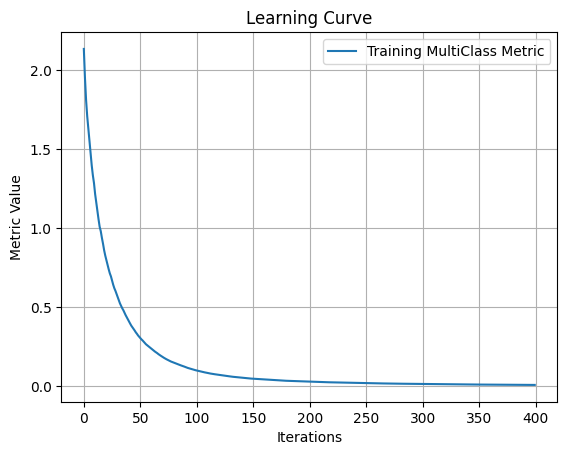

In [32]:
import matplotlib.pyplot as plt

# Plotting the learning curve
plt.plot(train_metric_values, label='Training MultiClass Metric')
plt.xlabel('Iterations')
plt.ylabel('Metric Value')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


Classification Report - Training Set:
                  precision    recall  f1-score   support

  F0_Normal_1_98       1.00      1.00      1.00       116
   F1_B007_1_124       1.00      1.00      1.00       124
   F2_B014_1_191       1.00      0.99      1.00       126
   F3_B021_1_228       0.99      1.00      1.00       128
  F4_IR007_1_111       1.00      1.00      1.00       123
  F5_IR014_1_176       1.00      1.00      1.00       125
  F6_IR021_1_215       1.00      1.00      1.00       130
F7_OR007_6_1_137       1.00      1.00      1.00       132
F8_OR014_6_1_203       1.00      1.00      1.00       112
F9_OR021_6_1_240       1.00      1.00      1.00       140

        accuracy                           1.00      1256
       macro avg       1.00      1.00      1.00      1256
    weighted avg       1.00      1.00      1.00      1256

Classification Report - Test Set:
                  precision    recall  f1-score   support

  F0_Normal_1_98       1.00      1.00      1.00       

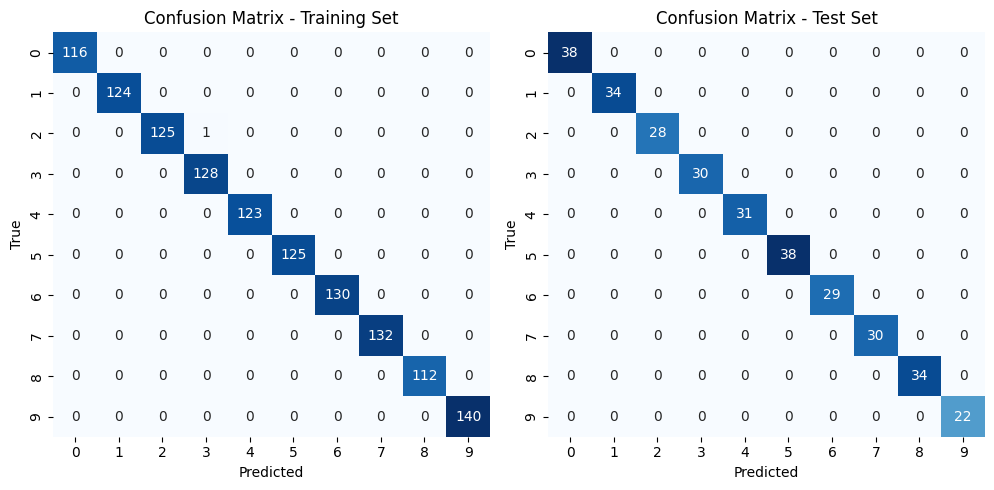

Deployment Duration: 0:04:51.000640


In [33]:
# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.savefig('C-Matrix.svg', format='svg')
plt.show()

end_time = datetime.now()
print('Deployment Duration: {}'.format(end_time - start_time))

In [34]:
final_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Evaluate train accuracy
result_train = final_model.score(X_train, y_train)
print("Train Accuracy : {}".format(result_train))

# Evaluate test accuracy
result_test = final_model.score(X_test, y_test)
print("Test Accuracy : {}".format(result_test))

# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Classification report
print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

0:	learn: 2.1365269	test: 2.1387502	best: 2.1387502 (0)	total: 3.69ms	remaining: 1.47s
10:	learn: 1.2171158	test: 1.1944795	best: 1.1944795 (10)	total: 59.6ms	remaining: 2.11s
20:	learn: 0.7968925	test: 0.7768096	best: 0.7768096 (20)	total: 130ms	remaining: 2.34s
30:	learn: 0.5615940	test: 0.5484273	best: 0.5484273 (30)	total: 202ms	remaining: 2.41s
40:	learn: 0.4089521	test: 0.3950612	best: 0.3950612 (40)	total: 285ms	remaining: 2.49s
50:	learn: 0.3046724	test: 0.2926605	best: 0.2926605 (50)	total: 311ms	remaining: 2.13s
60:	learn: 0.2350861	test: 0.2238449	best: 0.2238449 (60)	total: 337ms	remaining: 1.87s
70:	learn: 0.1841742	test: 0.1727878	best: 0.1727878 (70)	total: 365ms	remaining: 1.69s
80:	learn: 0.1481249	test: 0.1371056	best: 0.1371056 (80)	total: 407ms	remaining: 1.6s
90:	learn: 0.1209580	test: 0.1099013	best: 0.1099013 (90)	total: 469ms	remaining: 1.59s
100:	learn: 0.0992347	test: 0.0887448	best: 0.0887448 (100)	total: 547ms	remaining: 1.62s
110:	learn: 0.0830261	test: 0.0